# CIFAR10 Image Classification

Fast-forward to 2012, and we move on to the deeper and more modern AlexNet architecture. We will use the CIFAR10 dataset that uses 60,000 ImageNet samples, compressed to 32x32 pixel resolution (from the original 224x224), but still with three color channels. There are only 10 of the original 1,000 classes. See the notebook cifar10_image_classification for implementation details; we will skip here over some repetitive steps. 

## Run inside docker container for GPU acceleration

See [tensorflow guide](https://www.tensorflow.org/install/docker) and more detailed [instructions](https://blog.sicara.com/tensorflow-gpu-opencv-jupyter-docker-10705b6cd1d)

`docker run -it -p 8889:8888 -v /path/to/machine-learning-for-trading/17_convolutions_neural_nets:/cnn --name tensorflow tensorflow/tensorflow:latest-gpu-py3 bash`

Inside docker container: 
`jupyter notebook --ip 0.0.0.0 --no-browser --allow-root`

## Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.normalization import BatchNormalization
from keras import backend as K

Using TensorFlow backend.


In [4]:
np.random.seed(42)

## Load CIFAR-10 Data

CIFAR10 can also be downloaded from keras, and we similarly rescale the pixel values and one-hot encode the ten class labels. 

In [5]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### Visualize the First 30 Training Images

In [6]:
cifar10_labels = {0: 'airplane',
                  1: 'automobile',
                  2: 'bird',
                  3: 'cat',
                  4: 'deer',
                  5: 'dog',
                  6: 'frog',
                  7: 'horse',
                  8: 'ship',
                  9: 'truck'}

In [7]:
num_classes = len(cifar10_labels)

In [8]:
height, width, channels = X_train.shape[1:]
input_shape = height, width, channels
input_shape

(32, 32, 3)

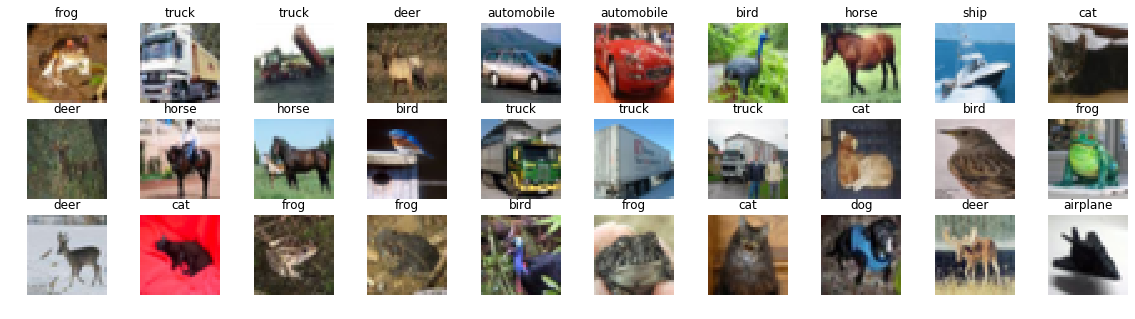

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_train[i]))
    ax.axis('off')
    ax.set_title(cifar10_labels[y_train[i, 0]])

### Rescale the Images

In [9]:
# rescale [0,255] --> [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255 

### One-hot label encoding

In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Train-Test split

In [11]:
X_train, X_valid = X_train[5000:], X_train[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]

In [12]:
# shape of training set
X_train.shape

(45000, 32, 32, 3)

In [13]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


## Feedforward Neural Network

We first train a two-layer feedforward network on 50,000 training samples for training for 20 epochs to achieve a test accuracy of 44.22%. We also experiment with a three-layer convolutional net with 500K parameters for 67.07% test accuracy.

### Model Architecture 

In [31]:
mlp = Sequential([
    Flatten(input_shape=input_shape, name='input'),
    Dense(1000, activation='relu', name='hidden_layer_1'),
    Dropout(0.2, name='droput_1'),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2, name='dropout_2'),
    Dense(num_classes, activation='softmax', name='output')
])

In [32]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 1000)              3073000   
_________________________________________________________________
droput_1 (Dropout)           (None, 1000)              0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 512)               512512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 10)                5130      
Total params: 3,590,642
Trainable params: 3,590,642
Non-trainable params: 0
_________________________________________________________________


### Compile the Model 

In [33]:
mlp.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

### Train the Model 

In [34]:
mlp_path = 'models/cifar10.mlp.weights.best.hdf5'

In [35]:
checkpointer = ModelCheckpoint(filepath=mlp_path, 
                               verbose=1, 
                               save_best_only=True)

In [36]:
tensorboard = TensorBoard(log_dir='./logs/mlp', 
                          histogram_freq=1, 
                          batch_size=32,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [19]:
hist = mlp.fit(X_train,
               y_train,
               batch_size=32,
               epochs=20,
               validation_data=(x_valid, y_valid),
               callbacks=[checkpointer, tensorboard],
               verbose=2,
               shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
 - 4s - loss: 1.9870 - acc: 0.2702 - val_loss: 1.8040 - val_acc: 0.3470

Epoch 00001: val_loss improved from inf to 1.80397, saving model to cifar10.mlp.weights.best.hdf5
Epoch 2/20
 - 4s - loss: 1.8563 - acc: 0.3209 - val_loss: 1.7918 - val_acc: 0.3574

Epoch 00002: val_loss improved from 1.80397 to 1.79179, saving model to cifar10.mlp.weights.best.hdf5
Epoch 3/20
 - 4s - loss: 1.8163 - acc: 0.3374 - val_loss: 1.7227 - val_acc: 0.3746

Epoch 00003: val_loss improved from 1.79179 to 1.72267, saving model to cifar10.mlp.weights.best.hdf5
Epoch 4/20
 - 4s - loss: 1.7955 - acc: 0.3450 - val_loss: 1.7177 - val_acc: 0.3956

Epoch 00004: val_loss improved from 1.72267 to 1.71774, saving model to cifar10.mlp.weights.best.hdf5
Epoch 5/20
 - 4s - loss: 1.7679 - acc: 0.3573 - val_loss: 1.6933 - val_acc: 0.3926

Epoch 00005: val_loss improved from 1.71774 to 1.69330, saving model to cifar10.mlp.weights.best.hdf5
Epoch 6/20
 - 4s - loss: 

### Load best model

In [37]:
# load the weights that yielded the best validation accuracy
mlp.load_weights(mlp_path)

### Test Classification Accuracy

In [38]:
# evaluate and print test accuracy
accuracy = mlp.evaluate(X_test, y_test, verbose=0)[1]
print('Test accuracy: {:.2%}'.format(accuracy))

Test accuracy: 44.22%


## Convolutional Neural Network

In [39]:
# https://stackoverflow.com/questions/35114376/error-when-computing-summaries-in-tensorflow/35117760#35117760
K.clear_session()

### Model Architecture

In [44]:
cnn = Sequential([
    Conv2D(filters=16, kernel_size=2, padding='same',
           activation='relu', input_shape=input_shape, name='CONV1'),
    MaxPooling2D(pool_size=2, name='POOL1'),
    Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', name='CONV2'),
    MaxPooling2D(pool_size=2, name='POOL2'),
    Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', name='CONV3'),
    MaxPooling2D(pool_size=2, name='POOL3'),
    Dropout(0.3, name='DROP1'),
    Flatten(name='FLAT1'),
    Dense(500, activation='relu', name='FC1'),
    Dropout(0.4, name='DROP2'),
    Dense(10, activation='softmax', name='FC2')]
)

In [45]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 32, 32, 16)        208       
_________________________________________________________________
POOL1 (MaxPooling2D)         (None, 16, 16, 16)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 16, 16, 32)        2080      
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 8, 8, 32)          0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 8, 8, 64)          8256      
_________________________________________________________________
POOL3 (MaxPooling2D)         (None, 4, 4, 64)          0         
_________________________________________________________________
DROP1 (Dropout)              (None, 4, 4, 64)          0         
__________

### Compile the Model

In [50]:
cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

### Train the Model

In [47]:
cnn_path = 'models/cifar10.cnn.weights.best.hdf5'

In [40]:
checkpointer = ModelCheckpoint(filepath=cnn_path, 
                               verbose=1, 
                               save_best_only=True)

In [41]:
tensorboard = TensorBoard(log_dir='./logs/cnn', 
                          histogram_freq=1, 
                          batch_size=32,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [42]:
hist = cnn.fit(x_train, 
               y_train, 
               batch_size=32, 
               epochs=20,
               validation_data=(x_valid, y_valid), 
               callbacks=[checkpointer, tensorboard], 
               verbose=2, 
               shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
 - 3s - loss: 1.5899 - acc: 0.4226 - val_loss: 1.4604 - val_acc: 0.4636

Epoch 00001: val_loss improved from inf to 1.46040, saving model to weights/cifar10.cnn.weights.best.hdf5
Epoch 2/20
 - 3s - loss: 1.2710 - acc: 0.5473 - val_loss: 1.2745 - val_acc: 0.5438

Epoch 00002: val_loss improved from 1.46040 to 1.27447, saving model to weights/cifar10.cnn.weights.best.hdf5
Epoch 3/20
 - 3s - loss: 1.1529 - acc: 0.5928 - val_loss: 1.0080 - val_acc: 0.6506

Epoch 00003: val_loss improved from 1.27447 to 1.00804, saving model to weights/cifar10.cnn.weights.best.hdf5
Epoch 4/20
 - 3s - loss: 1.0868 - acc: 0.6182 - val_loss: 1.0180 - val_acc: 0.6418

Epoch 00004: val_loss did not improve from 1.00804
Epoch 5/20
 - 3s - loss: 1.0414 - acc: 0.6385 - val_loss: 1.0208 - val_acc: 0.6478

Epoch 00005: val_loss did not improve from 1.00804
Epoch 6/20
 - 3s - loss: 1.0153 - acc: 0.6463 - val_loss: 0.9969 - val_acc: 0.6610

Epoch 00006: val_lo

### Load best model

In [51]:
cnn.load_weights(cnn_path)

### Test set accuracy

In [52]:
accuracy = cnn.evaluate(x_test, y_test, verbose=0)[1]
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 67.07%


### Evaluate Predictions

In [48]:
y_hat = cnn.predict(x_test)

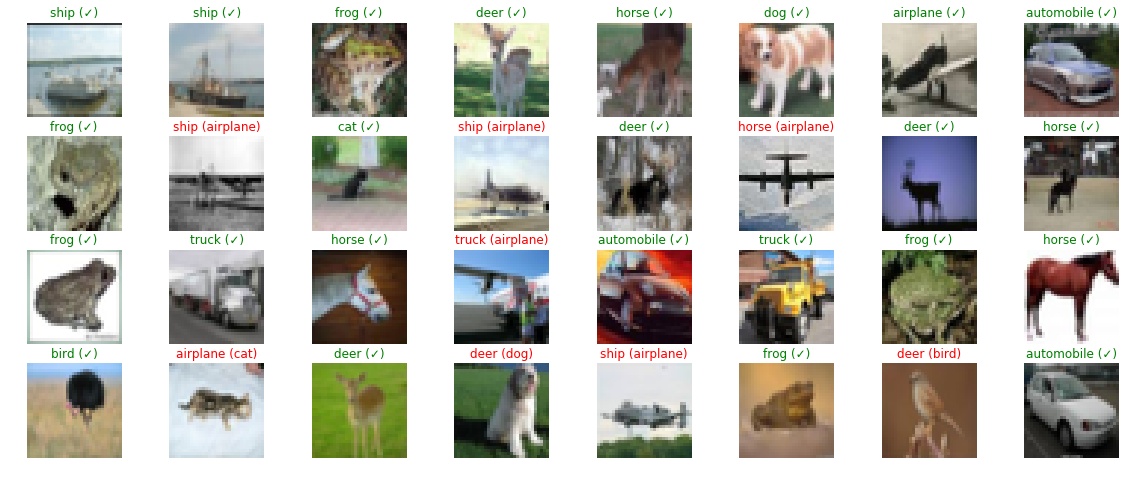

In [60]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 8))
axes = axes.flatten()
images = np.random.choice(x_test.shape[0], size=32, replace=False)
for i, (ax, idx) in enumerate(zip(axes, images)):
    ax.imshow(np.squeeze(x_test[idx]))
    ax.axis('off')
    pred_idx, true_idx = np.argmax(y_hat[idx]), np.argmax(y_test[idx])
    if pred_idx == true_idx:        
        ax.set_title('{} (✓)'.format(cifar10_labels[pred_idx]), color="green")
    else:
        ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]), color='red')

## CNN with Image Augmentation

A common trick to enhance performance is to artificially increase the size of the training set by creating synthetic data. This involves randomly shifting or horizontally flipping the image, or introducing noise into the image.

### Create and configure augmented image generator

Keras includes an ImageDataGenerator for this purpose that we can configure and fit to the training data as follows:

In [14]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly horizontal shift
    height_shift_range=0.1,  # randomly vertial shift
    horizontal_flip=True)  # randomly horizontalflip

In [15]:
# fit augmented image generator on data
datagen.fit(X_train)

### Visualize subset of training data

The result shows how the augmented images have been altered in various ways as expected:

In [25]:
n_images = 6
x_train_subset = X_train[:n_images]

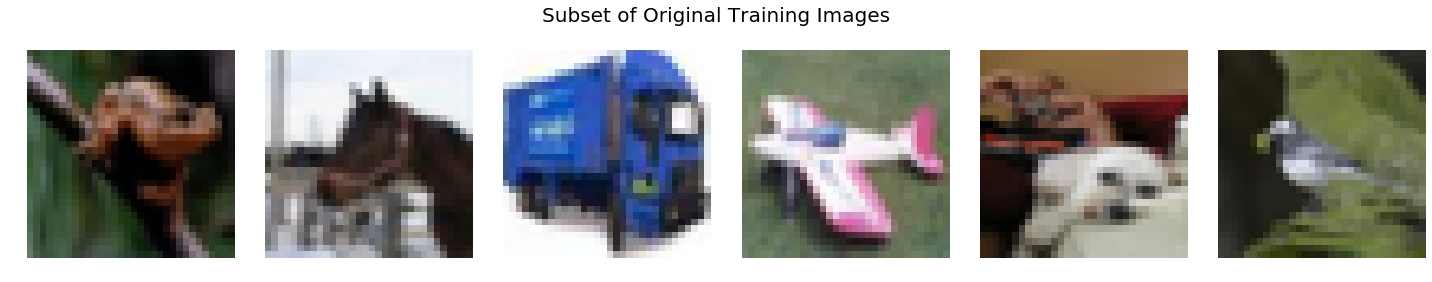

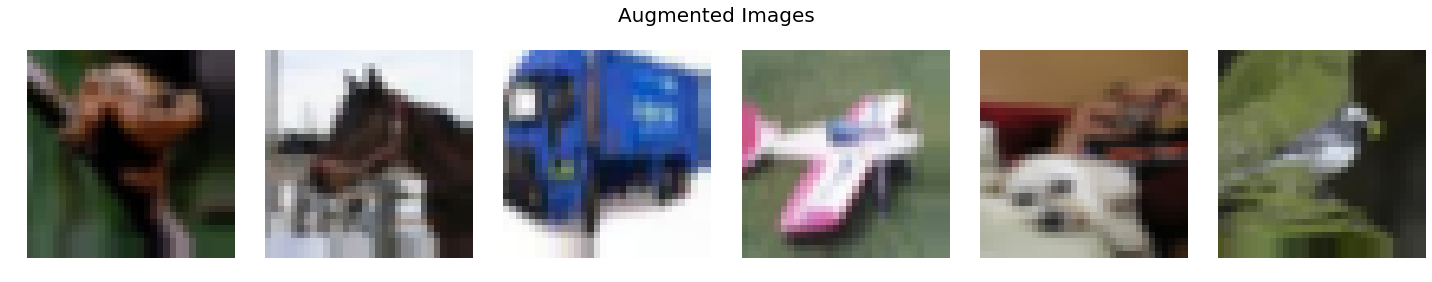

In [29]:
# original images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20,4))
for i, (ax, img) in enumerate(zip(axes, x_train_subset)):
    ax.imshow(img)
    ax.axis('off')
fig.suptitle('Subset of Original Training Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('images/original')

# augmented images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20,4))
for x_batch in datagen.flow(x_train_subset, batch_size=n_images, shuffle=False):
    for i, ax in enumerate(axes):
        ax.imshow(x_batch[i])
        ax.axis('off')
#     fig.suptitle('Augmented Images', fontsize=20)
    break;
fig.suptitle('Augmented Images', fontsize=20);
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('images/augmented')

### Train Augmented Images

In [57]:
K.clear_session()

In [58]:
cnn_aug_path = 'models/cifar10.augmented.cnn.weights.best.hdf5'

In [59]:
checkpointer = ModelCheckpoint(filepath=cnn_aug_path, 
                               verbose=1, 
                               save_best_only=True)

In [60]:
tensorboard = TensorBoard(log_dir='./logs/cnn_aug',
                          histogram_freq=1,
                          batch_size=32,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [64]:
cnn = Sequential([
    Conv2D(filters=16, kernel_size=2, padding='same',
           activation='relu', input_shape=input_shape, name='CONV1'),
    MaxPooling2D(pool_size=2, name='POOL1'),
    Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', name='CONV2'),
    MaxPooling2D(pool_size=2, name='POOL2'),
    Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', name='CONV3'),
    MaxPooling2D(pool_size=2, name='POOL3'),
    Dropout(0.3, name='DROP1'),
    Flatten(name='FLAT1'),
    Dense(500, activation='relu', name='FC1'),
    Dropout(0.4, name='DROP2'),
    Dense(10, activation='softmax', name='FC2')]
)

In [65]:
cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [61]:
batch_size = 32
epochs = 20

In [35]:
hist = cnn.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                         steps_per_epoch=x_train.shape[0] // batch_size,
                         epochs=epochs,
                         validation_data=(x_valid, y_valid), 
                         callbacks=[checkpointer, tensorboard], 
                         verbose=2)

Epoch 1/20
 - 11s - loss: 1.6158 - acc: 0.4087 - val_loss: 1.3774 - val_acc: 0.5012

Epoch 00001: val_loss improved from inf to 1.37738, saving model to weights/cifar10.augmented.cnn.weights.best.hdf5
Epoch 2/20
 - 11s - loss: 1.3582 - acc: 0.5123 - val_loss: 1.1724 - val_acc: 0.5846

Epoch 00002: val_loss improved from 1.37738 to 1.17241, saving model to weights/cifar10.augmented.cnn.weights.best.hdf5
Epoch 3/20
 - 11s - loss: 1.2461 - acc: 0.5545 - val_loss: 1.0761 - val_acc: 0.6208

Epoch 00003: val_loss improved from 1.17241 to 1.07606, saving model to weights/cifar10.augmented.cnn.weights.best.hdf5
Epoch 4/20
 - 11s - loss: 1.1795 - acc: 0.5782 - val_loss: 1.0266 - val_acc: 0.6334

Epoch 00004: val_loss improved from 1.07606 to 1.02659, saving model to weights/cifar10.augmented.cnn.weights.best.hdf5
Epoch 5/20
 - 11s - loss: 1.1184 - acc: 0.6008 - val_loss: 0.9402 - val_acc: 0.6626

Epoch 00005: val_loss improved from 1.02659 to 0.94016, saving model to weights/cifar10.augmented.c

### Load best model

In [66]:
cnn.load_weights(cnn_aug_path)

### Test set accuracy

The test accuracy for the three-layer CNN improves markedly to 74.79% after training on the larger, augmented data.

In [67]:
accuracy = cnn.evaluate(x_test, y_test, verbose=0)[1]
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 74.79%


## AlexNet

We also need to simplify the AlexNet architecture in response to the lower dimensionality of CIFAR10 images relative to the ImageNet samples used in the competition. We use the original number of filters but make them smaller (see notebook for implementation). The summary shows the five convolutional layers followed by two fully-connected layers with frequent use of batch normalization, for a total of 21.5 million parameters:

### Define Architecture

In [27]:
K.clear_session()

In [28]:
alexnet = Sequential([

    # 1st Convolutional Layer
    Conv2D(96, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=input_shape, name='CONV_1'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL_1'),
    BatchNormalization(name='NORM_1'),
    
    # 2nd Convolutional Layer
    Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu', name='CONV2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2,2), name='POOL2'),
    BatchNormalization(name='NORM_2'),
    
    # 3rd Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu', name='CONV3'),
    # 4th Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu', name='CONV4'),
    # 5th Convolutional Layer
    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='CONV5'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL5'),
    BatchNormalization(name='NORM_5'),
    
    # Fully Connected Layers
    Flatten(name='FLAT'),
    Dense(4096, input_shape=(32*32*3,), activation='relu', name='FC1'),
    Dropout(0.4, name='DROP1'),
    Dense(4096, activation='relu', name='FC2'),
    Dropout(0.4, name='DROP2'),
    Dense(num_classes, activation='softmax')
])

In [29]:
alexnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 16, 16, 96)        2688      
_________________________________________________________________
POOL_1 (MaxPooling2D)        (None, 8, 8, 96)          0         
_________________________________________________________________
NORM_1 (BatchNormalization)  (None, 8, 8, 96)          384       
_________________________________________________________________
CONV2 (Conv2D)               (None, 8, 8, 256)         614656    
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 3, 3, 256)         0         
_________________________________________________________________
NORM_2 (BatchNormalization)  (None, 3, 3, 256)         1024      
_________________________________________________________________
CONV3 (Conv2D)               (None, 3, 3, 384)         885120    
__________

### Compile Model

In [30]:
alexnet.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

### Train Model

In [31]:
batch_size = 32
epochs = 20

In [32]:
alexnet_path = 'models/cifar10.augmented.alexnet.weights.best.hdf5'

In [33]:
checkpointer = ModelCheckpoint(filepath=alexnet_path, 
                               verbose=1, 
                               save_best_only=True)

In [34]:
tensorboard = TensorBoard(log_dir='./logs/alexnet', 
                          histogram_freq=1, 
                          batch_size=batch_size,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [35]:
alexnet.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                      steps_per_epoch=X_train.shape[0] // batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard],
                      verbose=1)

Epoch 1/20
1406/1406 [==============================] - 24s 17ms/step - loss: 1.7045 - acc: 0.3855 - val_loss: 1.5554 - val_acc: 0.4586

Epoch 00001: val_loss improved from inf to 1.55539, saving model to models/cifar10.augmented.alexnet.weights.best.hdf5
Epoch 2/20
1406/1406 [==============================] - 24s 17ms/step - loss: 1.4137 - acc: 0.5014 - val_loss: 1.5889 - val_acc: 0.4762

Epoch 00002: val_loss did not improve from 1.55539
Epoch 3/20
1406/1406 [==============================] - 24s 17ms/step - loss: 1.2087 - acc: 0.5785 - val_loss: 1.4027 - val_acc: 0.5114

Epoch 00003: val_loss improved from 1.55539 to 1.40270, saving model to models/cifar10.augmented.alexnet.weights.best.hdf5
Epoch 4/20
1406/1406 [==============================] - 24s 17ms/step - loss: 1.1051 - acc: 0.6204 - val_loss: 1.1670 - val_acc: 0.6126

Epoch 00004: val_loss improved from 1.40270 to 1.16702, saving model to models/cifar10.augmented.alexnet.weights.best.hdf5
Epoch 5/20
1406/1406 [==============

In [36]:
alexnet.load_weights(alexnet_path)

After training for 20 episodes, each of which takes a little under 30 seconds on a single GPU, we obtain 76.84% test accuracy.

In [37]:
accuracy = alexnet.evaluate(X_test, y_test, verbose=0)[1]
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 76.84%
